- **Author:** [Dace Apšvalka](https://www.mrc-cbu.cam.ac.uk/people/dace.apsvalka/) with edits by [Rik Henson](https://www.mrc-cbu.cam.ac.uk/people/rik.henson/)
- **Date:** November 2024
- **conda environment**: This uses the [mri environment](https://github.com/RikHenson/PythonNeuroimagingCourse/blob/main/mri_environment.yml)

# fMRI Data Analysis: Group-Level Analysis

Once you have beta (or contrast) maps for conditions (or contrasts) from all subjects, you can perform group-level statistics. Importantly, all subject first-level results need to be in common space, e.g., MNI, to perform voxel-wise group analyses. Group-level analysis allows you to make inferences about the population, rather than individual subjects, by assessing common activations across participants. Common statistical methods for group-level analysis include one-sample or paired t-tests, as well as more complex ANOVA models, depending on your study design.

In this tutorial, we illustrate a simple one-sample t-test on the contrast of Faces-Scrambled that we calculated for each subject in the previous notebook.

-----
## Import required packages and set up some stuff

In [1]:
# The conda environment used for this tutorial is available here: https://github.com/MRC-CBU/COGNESTIC/blob/main/mri_environment.yml 
import os
import glob   # to search for files using regex
import pandas # for data manipulation
import numpy  # for numerical operations

from bids.layout import BIDSLayout # to fetch data from BIDS-compliant datasets
import matplotlib.pyplot as plt # for basic plotting

import nibabel  # to read and write neuroimaging data, https://nipy.org/nibabel/

# Nilearn modules, for the analysis of brain volumes, plotting, etc., https://nilearn.github.io/
from nilearn.plotting import plot_glass_brain, plot_design_matrix, plot_contrast_matrix, plot_stat_map, view_img, view_img_on_surf
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.thresholding import threshold_stats_img
from nilearn.datasets import load_mni152_template
# from nilearn.glm.second_level import non_parametric_inference


# to show plots in cell
%matplotlib inline   

wd = '/home/mohamed/Documents/ISN2025/FaceRecognition' # <-- CHANGE TO YOURS
os.chdir(wd)
print(f"Working directory currently {os.getcwd()}")

Working directory currently /home/mohamed/Documents/ISN2025/FaceRecognition


In [2]:
# MNI152 template will be used as a backgound for plotting results
mni152_template = load_mni152_template()

## Retrieve First-Level results

For the group analysis, we will use the single-condition contrast estimate (beta estimate) maps for all nine conditions. Because we saved the results in BIDS format, we can us PyBIDS to retrieve the subject-level results. 

Note that if you did not run first-level models for all subjects, you can download the contrast images needed from the `results/first-level` directory from [https://cloud.mrc-cbu.cam.ac.uk/index.php/s/3AFA0yF7QK9qIaO](https://cloud.mrc-cbu.cam.ac.uk/index.php/s/3AFA0yF7QK9qIaO). The password for this cloud directory will be given by the course organiser.

In [3]:
# --- Set up the paths to the data and results folders
fmri_data_dir = 'data' # data in BIDS format
fmri_results_dir = 'results' # results in BIDS format

fmri_group_dir = os.path.join(fmri_results_dir, 'group-level') # where group results will go
try: 
    os.mkdir(fmri_group_dir)
except: None

# --- Set up the BIDS layout
layout = BIDSLayout(fmri_data_dir, derivatives = True)

# Attach the results folder to the layout. It must comply with BIDS standards, and include dataset_description.json file!
layout.add_derivatives(os.path.join(fmri_results_dir, "first-level"))
subjects = layout.get_subjects()

/home/mohamed/anaconda3/envs/mri/lib/python3.11/site-packages/bids/layout/layout.py:516: UserWarning: Derivative indexing was requested, but no valid datasets were found in the specified locations ([PosixPath('/home/mohamed/Documents/ISN2025/FaceRecognition/data/derivatives')]). Note that all BIDS-Derivatives datasets must meet all the requirements for BIDS-Raw datasets (a common problem is to fail to include a 'dataset_description.json' file in derivatives datasets).
Example contents of 'dataset_description.json':
{"Name": "Example dataset", "BIDSVersion": "1.0.2", "GeneratedBy": [{"Name": "Example pipeline"}]}
  warnings.warn("Derivative indexing was requested, but no valid "


Specify which conditions to include in the analysis and retrieve their effect files from the first-level results.

## Displaying Z-maps for each subject

To check how the first-level results look overall, it is helpful to display the Faces-Scrambled contrast for all subjects. Let's find these and then plot.

In [14]:
fac_scr_maps = layout.get(desc='FacesScrambled', suffix="effect", extension='.nii.gz', return_type='file')
print(*fac_scr_maps, sep="\n")

/home/mohamed/Documents/ISN2025/FaceRecognition/results/first-level/sub-01/sub-01_ses-mri_task-facerecognition_desc-FacesScrambled_effect.nii.gz
/home/mohamed/Documents/ISN2025/FaceRecognition/results/first-level/sub-02/sub-02_ses-mri_task-facerecognition_desc-FacesScrambled_effect.nii.gz
/home/mohamed/Documents/ISN2025/FaceRecognition/results/first-level/sub-03/sub-03_ses-mri_task-facerecognition_desc-FacesScrambled_effect.nii.gz
/home/mohamed/Documents/ISN2025/FaceRecognition/results/first-level/sub-04/sub-04_ses-mri_task-facerecognition_desc-FacesScrambled_effect.nii.gz
/home/mohamed/Documents/ISN2025/FaceRecognition/results/first-level/sub-05/sub-05_ses-mri_task-facerecognition_desc-FacesScrambled_effect.nii.gz
/home/mohamed/Documents/ISN2025/FaceRecognition/results/first-level/sub-06/sub-06_ses-mri_task-facerecognition_desc-FacesScrambled_effect.nii.gz
/home/mohamed/Documents/ISN2025/FaceRecognition/results/first-level/sub-07/sub-07_ses-mri_task-facerecognition_desc-FacesScrambled

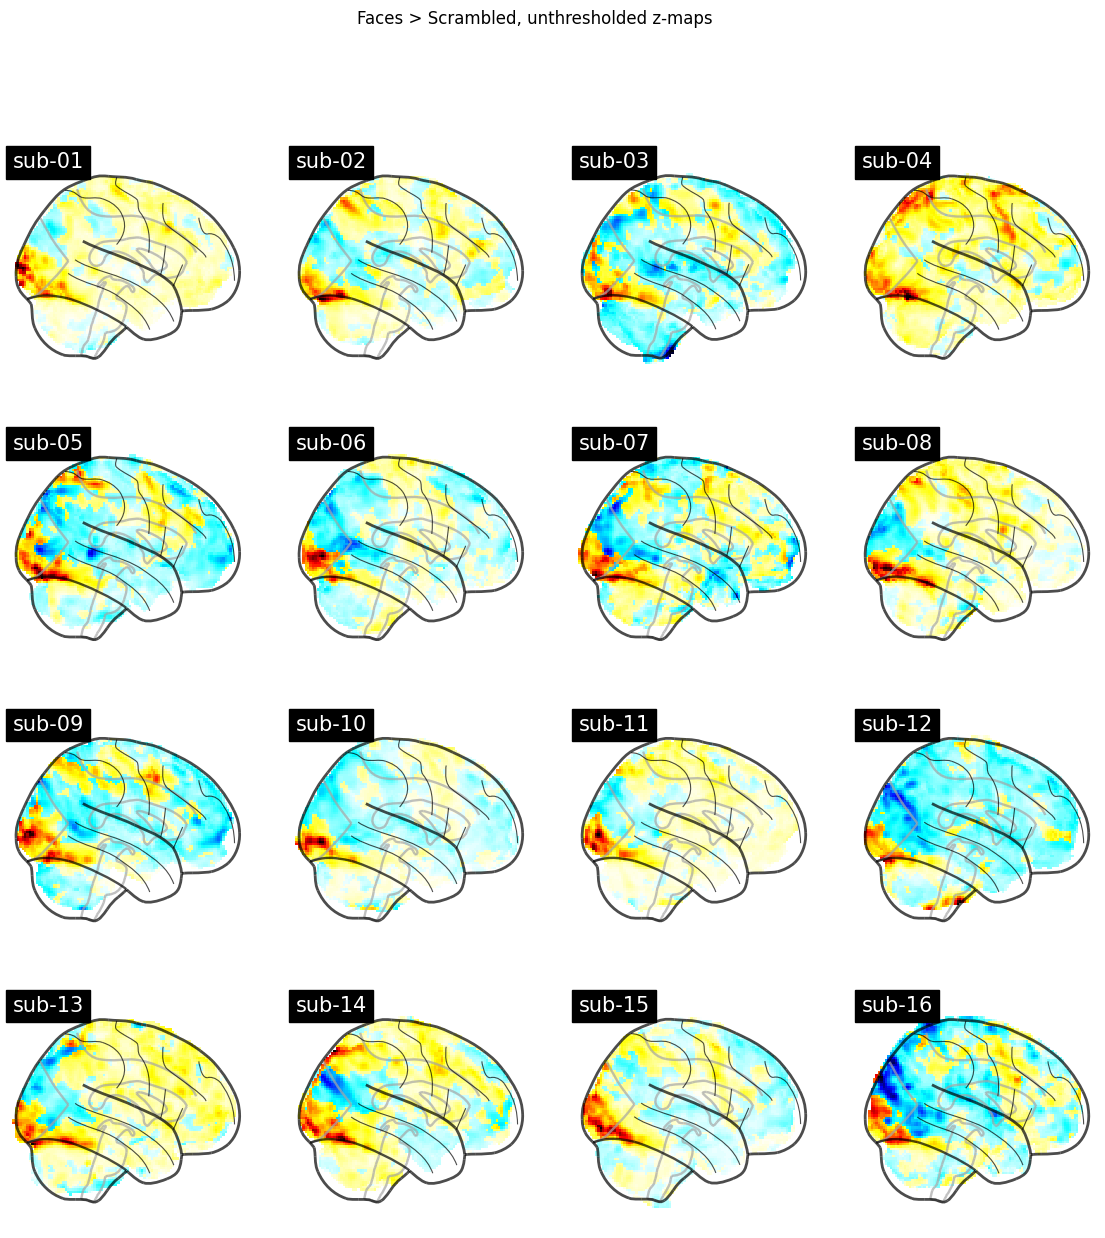

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(14, 14));

for i, stat_map in enumerate(fac_scr_maps):
    plot_glass_brain(stat_map, title = 'sub-' + subjects[i],
                               axes = axes[int(i / 4), int(i % 4)],
                               plot_abs = False, 
                               display_mode='x')
fig.suptitle('Faces > Scrambled' + ', unthresholded z-maps');

## Specify second-level models

At the group-level analysis, we also use a GLM. The outcome variable is the beta/contrast estimate from each subject, and the predictor variables typically include group-level factors such as experimental conditions, subject-specific regressors (in repeated-measures designs), group-specific regressors (in between-subject designs), and subject-specific covariates (e.g., age, gender, or behavioural scores). First we start with the simplest of all GLMs: the one-sample T-test...

### One-sample T-test for Faces > Scrambled

One approach is to define all one's contrasts in the first-level (individual subject) models, and take these to the second-level. When those contrasts are all T-contrasts (one-dimensional), the second level model corresponds to a one-sample T-test, i.e, testing whether those contrasts are significantly above or below zero when averaged across participants. This is called the "partitioned error" or "summary statistic" approach (such that the error in the one-sample t-test corresponds to the contrast x subject interaction in a repeated-measures ANOVA). With this approach, one has to estimate a new second-level model for each contrast of interest. See Notebook 00 for more information (e.g, how to handle F-contrasts in such cases).

Later we will try the alternative approach, which is to take the Betas (averaged across runs) for all of the individual conditions into a larger ANOVA model at the second-level (in our case, all 9 conditions, corresponding to a 3x3 ANOVA). This is called the "pooled error" approach. This can be more powerful, and simpler, because all one's contrasts can be tested within a single model. However, it makes stronger assumptions about the sphericity of the error, which may be violated, which is why the above "partitioned error" approach is generally safer. Again, see Notebook 00 for more information.

In [17]:
design_matrix = pandas.DataFrame([1]*len(subjects), index=subjects, columns=["fac-scr"])
second_level_model = SecondLevelModel() 
second_level_model = second_level_model.fit(
  fac_scr_maps, 
  design_matrix = design_matrix )

Let's search the brain for voxels showing more activation for faces than scrambled faces. We will start by using an uncorrected threshold of p<001 (later we will illustrate some corrected thresholds):

The cross-hair shows a cluster in a right mid-fusiform region, close to what is sometimes called the "Fusiform Face Area" (FFA). Also activated (in orange) are bilateral anterior medial temporal lobe regions (around amygdala), as well as more posterior bilateral occipital regions (sometimes called OFA). 

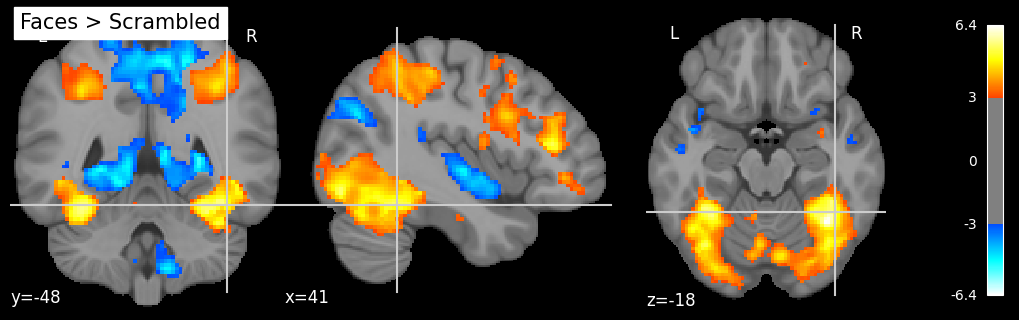

In [21]:
contrasts = {'FacesScrambled': [1]}
z_map = second_level_model.compute_contrast(contrasts['FacesScrambled'], output_type="z_score")
thresholded_map_fpr, threshold_fpr = threshold_stats_img(
    z_map, 
    alpha=0.001, 
    height_control=None, 
    cluster_threshold=0,
    two_sided=True)

plot_stat_map(
    thresholded_map_fpr,
    bg_img = mni152_template, 
    threshold = threshold_fpr,   
    display_mode = 'ortho',
    black_bg = True,    
    cut_coords=(41.5, -48.5, -18.5), # to put cross-hair on right FFA (to match ANOVA results below)
title = 'Faces > Scrambled')
fig = plt.gcf(); fig.set_size_inches(10,3); plt.show();